
# Demographic Bias Analysis in Cancer Genomic Atlas (TCGA) Dataset
================================================================

### This script analyzes potential demographic biases in the TCGA dataset, specifically focusing on ethnic representation and other demographic factors that could affect AI-driven personalized medicine recommendations.

In [13]:
# Import all necessary libraries for data analysis, modeling, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

###    Analyzer for demographic biases in genomic datasets


In [14]:
# This class encapsulates all logic for analyzing demographic bias in synthetic clinical/genomic data
class DemographicBiasAnalyzer:
    def __init__(self):
        # Initialize storage for demographic data and bias metrics
        self.demographic_data = None
        self.bias_metrics = {}

    def load_tcga_demographics(self, file_path=None):
        """
        Load TCGA demographic data or create synthetic data for analysis.
        If no file is provided, synthetic data is generated for demonstration.
        """
        if file_path and os.path.exists(file_path):
            self.demographic_data = pd.read_csv(file_path)
        else:
            self.demographic_data = self._create_synthetic_tcga_data()
        return self.demographic_data

    def _create_synthetic_tcga_data(self, n_samples=1000):
        """
        Create synthetic TCGA demographic data for bias analysis demonstration.
        """
        np.random.seed(42)
        # Define demographic categories with realistic distributions
        ethnicities = ['White', 'Black/African American', 'Asian', 'Hispanic/Latino', 'Other']
        ethnicity_weights = [0.75, 0.08, 0.05, 0.08, 0.04]  # Reflecting typical TCGA distribution
        cancer_types = ['Breast', 'Lung', 'Colon', 'Prostate', 'Ovarian', 'Melanoma']
        cancer_weights = [0.25, 0.20, 0.15, 0.15, 0.10, 0.15]
        ages = np.random.normal(65, 15, n_samples)
        ages = np.clip(ages, 18, 95)
        data = {
            'patient_id': [f'TCGA-{i:06d}' for i in range(n_samples)],
            'age': ages,
            'ethnicity': np.random.choice(ethnicities, n_samples, p=ethnicity_weights),
            'gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.45, 0.55]),
            'cancer_type': np.random.choice(cancer_types, n_samples, p=cancer_weights),
            'stage': np.random.choice(['I', 'II', 'III', 'IV'], n_samples, p=[0.3, 0.3, 0.25, 0.15]),
            'income_level': np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.3, 0.5, 0.2]),
            'geographic_region': np.random.choice(['Northeast', 'South', 'Midwest', 'West'], n_samples, p=[0.25, 0.35, 0.20, 0.20])
        }
        return pd.DataFrame(data)

    def analyze_ethnic_representation(self):
        """
        Analyze ethnic representation in the dataset and compare to US population.
        """
        print("=== ETHNIC REPRESENTATION ANALYSIS ===\n")
        ethnicity_counts = self.demographic_data['ethnicity'].value_counts()
        total_patients = len(self.demographic_data)
        print("Ethnic Distribution:")
        for ethnicity, count in ethnicity_counts.items():
            percentage = (count / total_patients) * 100
            print(f"  {ethnicity}: {count} patients ({percentage:.1f}%)")
        us_population_2010 = {
            'White': 72.4,
            'Black/African American': 12.6,
            'Asian': 4.8,
            'Hispanic/Latino': 16.3,
            'Other': 2.0
        }
        print(f"\nRepresentation vs. US Population (2010 Census):")
        for ethnicity in ethnicity_counts.index:
            if ethnicity in us_population_2010:
                dataset_pct = (ethnicity_counts[ethnicity] / total_patients) * 100
                us_pct = us_population_2010[ethnicity]
                bias_ratio = dataset_pct / us_pct
                print(f"  {ethnicity}: Dataset {dataset_pct:.1f}% vs US {us_pct:.1f}% (Ratio: {bias_ratio:.2f})")
        self.bias_metrics['ethnic_representation'] = {
            'counts': ethnicity_counts.to_dict(),
            'percentages': (ethnicity_counts / total_patients * 100).to_dict(),
            'us_population_comparison': us_population_2010
        }
        return ethnicity_counts

    def analyze_age_distribution(self):
        """
        Analyze age distribution across different demographic groups.
        """
        print("\n=== AGE DISTRIBUTION ANALYSIS ===\n")
        print(f"Overall Age Statistics:")
        print(f"  Mean age: {self.demographic_data['age'].mean():.1f} years")
        print(f"  Median age: {self.demographic_data['age'].median():.1f} years")
        print(f"  Age range: {self.demographic_data['age'].min():.1f} - {self.demographic_data['age'].max():.1f} years")
        print(f"\nAge Distribution by Ethnicity:")
        age_by_ethnicity = self.demographic_data.groupby('ethnicity')['age'].agg(['mean', 'std', 'count'])
        for ethnicity in age_by_ethnicity.index:
            mean_age = age_by_ethnicity.loc[ethnicity, 'mean']
            std_age = age_by_ethnicity.loc[ethnicity, 'std']
            count = age_by_ethnicity.loc[ethnicity, 'count']
            print(f"  {ethnicity}: {mean_age:.1f} ± {std_age:.1f} years (n={count})")
        print(f"\nAge Bias Analysis:")
        overall_mean = self.demographic_data['age'].mean()
        for ethnicity in age_by_ethnicity.index:
            ethnic_mean = age_by_ethnicity.loc[ethnicity, 'mean']
            age_bias = ethnic_mean - overall_mean
            print(f"  {ethnicity}: {age_bias:+.1f} years from overall mean")
        self.bias_metrics['age_distribution'] = age_by_ethnicity.to_dict()
        return age_by_ethnicity

    def analyze_cancer_type_distribution(self):
        """
        Analyze cancer type distribution across demographic groups.
        """
        print("\n=== CANCER TYPE DISTRIBUTION ANALYSIS ===\n")
        cancer_counts = self.demographic_data['cancer_type'].value_counts()
        print("Overall Cancer Type Distribution:")
        for cancer_type, count in cancer_counts.items():
            percentage = (count / len(self.demographic_data)) * 100
            print(f"  {cancer_type}: {count} patients ({percentage:.1f}%)")
        print(f"\nCancer Type Distribution by Ethnicity:")
        cancer_ethnicity = pd.crosstab(self.demographic_data['cancer_type'], 
                                      self.demographic_data['ethnicity'], 
                                      normalize='columns') * 100
        for ethnicity in cancer_ethnicity.columns:
            print(f"\n  {ethnicity}:")
            for cancer_type in cancer_ethnicity.index:
                percentage = cancer_ethnicity.loc[cancer_type, ethnicity]
                print(f"    {cancer_type}: {percentage:.1f}%")
        self.bias_metrics['cancer_type_distribution'] = {
            'overall': cancer_counts.to_dict(),
            'by_ethnicity': cancer_ethnicity.to_dict()
        }
        return cancer_ethnicity

    def analyze_socioeconomic_bias(self):
        """
        Analyze socioeconomic factors and their relationship to other variables.
        """
        print("\n=== SOCIOECONOMIC BIAS ANALYSIS ===\n")
        income_counts = self.demographic_data['income_level'].value_counts()
        print("Income Level Distribution:")
        for income, count in income_counts.items():
            percentage = (count / len(self.demographic_data)) * 100
            print(f"  {income}: {count} patients ({percentage:.1f}%)")
        print(f"\nIncome Level by Ethnicity:")
        income_ethnicity = pd.crosstab(self.demographic_data['income_level'], 
                                      self.demographic_data['ethnicity'], 
                                      normalize='columns') * 100
        for ethnicity in income_ethnicity.columns:
            print(f"\n  {ethnicity}:")
            for income in income_ethnicity.index:
                percentage = income_ethnicity.loc[income, ethnicity]
                print(f"    {income}: {percentage:.1f}%")
        print(f"\nGeographic Distribution:")
        geo_counts = self.demographic_data['geographic_region'].value_counts()
        for region, count in geo_counts.items():
            percentage = (count / len(self.demographic_data)) * 100
            print(f"  {region}: {count} patients ({percentage:.1f}%)")
        self.bias_metrics['socioeconomic'] = {
            'income_distribution': income_counts.to_dict(),
            'income_by_ethnicity': income_ethnicity.to_dict(),
            'geographic_distribution': geo_counts.to_dict()
        }
        return income_ethnicity

    def generate_bias_report(self):
        """
        Generate a comprehensive bias report with key findings and recommendations.
        """
        print("\n" + "="*60)
        print("COMPREHENSIVE BIAS ANALYSIS REPORT")
        print("="*60)
        print("\nKEY FINDINGS:")
        ethnic_counts = self.demographic_data['ethnicity'].value_counts()
        total = len(self.demographic_data)
        print("\n1. ETHNIC REPRESENTATION BIASES:")
        for ethnicity, count in ethnic_counts.items():
            pct = (count / total) * 100
            if pct < 5:
                print(f"   ⚠️  {ethnicity} severely underrepresented ({pct:.1f}%)")
            elif pct < 10:
                print(f"   ⚠️  {ethnicity} underrepresented ({pct:.1f}%)")
            else:
                print(f"   ✓ {ethnicity} adequately represented ({pct:.1f}%)")
        age_by_ethnicity = self.demographic_data.groupby('ethnicity')['age'].mean()
        overall_mean = self.demographic_data['age'].mean()
        print("\n2. AGE DISTRIBUTION BIASES:")
        for ethnicity, mean_age in age_by_ethnicity.items():
            bias = mean_age - overall_mean
            if abs(bias) > 5:
                print(f"   ⚠️  {ethnicity} age bias: {bias:+.1f} years from mean")
            else:
                print(f"   ✓ {ethnicity} age distribution within normal range")
        print("\n3. CANCER TYPE REPRESENTATION:")
        cancer_counts = self.demographic_data['cancer_type'].value_counts()
        for cancer_type, count in cancer_counts.items():
            pct = (count / total) * 100
            print(f"   {cancer_type}: {pct:.1f}% of dataset")
        print("\nRECOMMENDATIONS FOR MITIGATING BIAS:")
        print("1. Increase recruitment of underrepresented ethnic groups")
        print("2. Ensure balanced age distribution across all ethnicities")
        print("3. Implement stratified sampling for cancer types")
        print("4. Regular bias audits of AI models")
        print("5. Transparent reporting of demographic distributions")
        print("6. Validation on diverse external datasets")
        return self.bias_metrics

    def create_visualizations(self):
        """
        Create and save visualizations for the bias analysis results.
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Demographic Bias Analysis in TCGA Dataset', fontsize=16)
        # 1. Ethnic distribution
        ethnic_counts = self.demographic_data['ethnicity'].value_counts()
        axes[0, 0].pie(ethnic_counts.values, labels=ethnic_counts.index, autopct='%1.1f%%')
        axes[0, 0].set_title('Ethnic Distribution')
        # 2. Age distribution by ethnicity
        sns.boxplot(data=self.demographic_data, x='ethnicity', y='age', ax=axes[0, 1])
        axes[0, 1].set_title('Age Distribution by Ethnicity')
        axes[0, 1].tick_params(axis='x', rotation=45)
        # 3. Cancer type distribution
        cancer_counts = self.demographic_data['cancer_type'].value_counts()
        axes[1, 0].bar(cancer_counts.index, cancer_counts.values)
        axes[1, 0].set_title('Cancer Type Distribution')
        axes[1, 0].tick_params(axis='x', rotation=45)
        # 4. Income level by ethnicity
        income_ethnicity = pd.crosstab(self.demographic_data['income_level'], 
                                      self.demographic_data['ethnicity'])
        income_ethnicity.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Income Level by Ethnicity')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('demographic_bias_visualizations.png', dpi=300, bbox_inches='tight')
        plt.show()

### Main Function

In [15]:
# This function runs the full demographic bias analysis pipeline
def main():
    print("Demographic Bias Analysis in Cancer Genomic Atlas Dataset")
    print("=" * 60)
    analyzer = DemographicBiasAnalyzer()
    print("Loading TCGA demographic data...")
    analyzer.load_tcga_demographics()
    analyzer.analyze_ethnic_representation()
    analyzer.analyze_age_distribution()
    analyzer.analyze_cancer_type_distribution()
    analyzer.analyze_socioeconomic_bias()
    bias_metrics = analyzer.generate_bias_report()
    print("\nGenerating visualizations...")
    analyzer.create_visualizations()
    print("\nAnalysis complete! Check 'analysis/demographic_bias_visualizations.png' for visualizations.")

### Run the Main Function

Demographic Bias Analysis in Cancer Genomic Atlas Dataset
Loading TCGA demographic data...
=== ETHNIC REPRESENTATION ANALYSIS ===

Ethnic Distribution:
  White: 752 patients (75.2%)
  Black/African American: 85 patients (8.5%)
  Hispanic/Latino: 64 patients (6.4%)
  Asian: 54 patients (5.4%)
  Other: 45 patients (4.5%)

Representation vs. US Population (2010 Census):
  White: Dataset 75.2% vs US 72.4% (Ratio: 1.04)
  Black/African American: Dataset 8.5% vs US 12.6% (Ratio: 0.67)
  Hispanic/Latino: Dataset 6.4% vs US 16.3% (Ratio: 0.39)
  Asian: Dataset 5.4% vs US 4.8% (Ratio: 1.13)
  Other: Dataset 4.5% vs US 2.0% (Ratio: 2.25)

=== AGE DISTRIBUTION ANALYSIS ===

Overall Age Statistics:
  Mean age: 65.1 years
  Median age: 65.4 years
  Age range: 18.0 - 95.0 years

Age Distribution by Ethnicity:
  Asian: 65.6 ± 13.3 years (n=54)
  Black/African American: 69.2 ± 14.4 years (n=85)
  Hispanic/Latino: 64.5 ± 14.4 years (n=64)
  Other: 62.5 ± 14.5 years (n=45)
  White: 64.9 ± 14.3 years (n=

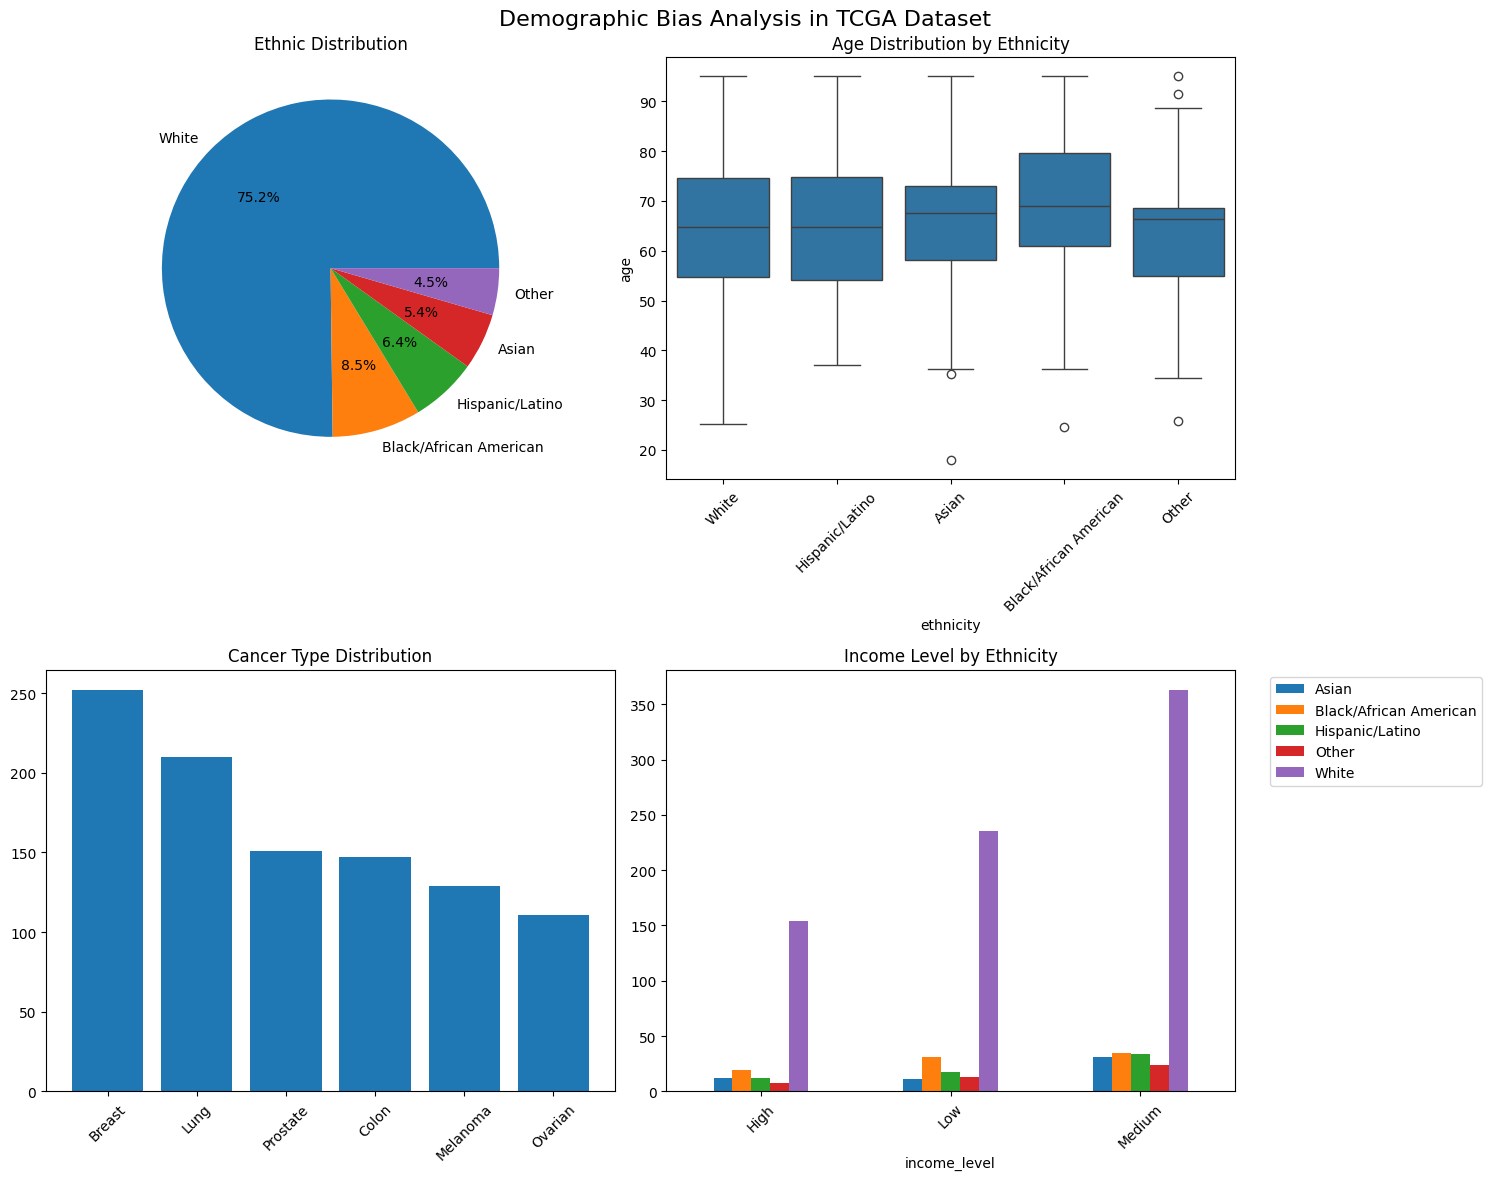


Analysis complete! Check 'analysis/demographic_bias_visualizations.png' for visualizations.


In [16]:
# Run the demographic bias analysis
main()